In this notebook,
we study out-of-basis least squares learning.

### Load libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dataclasses
import logging
import os
import sys
import warnings
from typing import Callable

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from tqdm.auto import tqdm

logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"


In [3]:
sys.path.append("../..")

from src import utils
from src.experiments.harmonics.data import (
    HypercubeDataModule,
    HypercubeDataModuleConfig,
)
from src.experiments.harmonics.harmonics import HarmonicFn, HarmonicFnConfig
from src.experiments.harmonics.poly import ChebPoly

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


### Utility code

In [4]:
def get_mse(
    model: pl.LightningModule,
    dl: torch.utils.data.DataLoader,
) -> torch.Tensor:
    return pl.Trainer(enable_progress_bar=False).test(
        model=model,
        dataloaders=dl,
        verbose=False,
    )[0]["test_mse"]


@dataclasses.dataclass(frozen=True)
class LSData:
    ns: np.ndarray
    val_mses: np.ndarray


def run_lstsq_exp(
    ns: list[int],
    true_fn: Callable[[torch.Tensor], torch.Tensor],
    estimator: Callable[[np.ndarray, np.ndarray], pl.LightningModule],
    input_dim: int,
    noise_std: float = 0.0,
    n_val: int = 1024,
) -> np.ndarray:
    val_mses = []
    for n_train in tqdm(ns):
        dm = HypercubeDataModule(
            fn=true_fn,
            cfg=HypercubeDataModuleConfig(
                input_dim=input_dim,
                n_train=n_train,
                n_val=n_val,
                train_seed=n_train,
                val_seed=-1,
                num_workers=0,
                batch_size=256,
            ),
        )
        dm.setup()

        xs_train = dm.train_ds.tensors[0].numpy()
        ys_train = dm.train_ds.tensors[1].numpy()

        fn_hat = estimator(
            xs_train,
            ys_train + noise_std * np.random.normal(size=len(ys_train)),
        )

        mse = get_mse(model=fn_hat, dl=dm.val_dataloader())
        val_mses.append(mse)

    return LSData(
        ns=np.array(ns),
        val_mses=np.array(val_mses),
    )


### Groundtruth functions

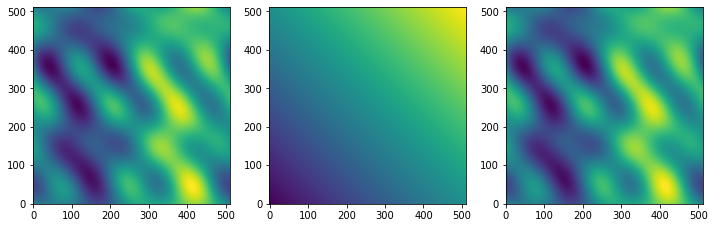

In [5]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
FN_H = HarmonicFn(
    HarmonicFnConfig(
        input_dim=2,
        freq_limit=3,
        num_components=12,
        dtype=torch.float64,
    )
)
utils.viz_2d_hd(pred_fn=FN_H, side_samples=512, pad=(0, 0));

plt.subplot(1, 3, 2)
FN_SUM = lambda x: 0.001 * x.sum(dim=-1)
utils.viz_2d_hd(pred_fn=FN_SUM, side_samples=512, pad=(0, 0));

plt.subplot(1, 3, 3)
FN_HSUM = lambda x: FN_H(x) + FN_SUM(x)
utils.viz_2d_hd(pred_fn=FN_HSUM, side_samples=512, pad=(0, 0));

### Manual run

Train MSE: 2.8866995904763826e-08
Test MSE: 2.8892175762962324e-08
Test MSE - irreduc.: 1.3489794281096398e-10


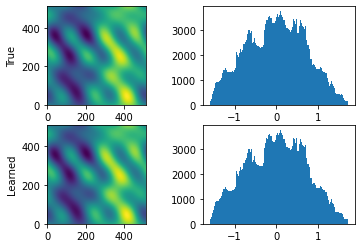

In [6]:
TRUE_FN = FN_HSUM

dm = HypercubeDataModule(
    fn=TRUE_FN,
    cfg=HypercubeDataModuleConfig(
        input_dim=2,
        n_train=50_000,
        n_val=100_000,
        train_seed=-1,
        val_seed=100,
        num_workers=0,
        batch_size=256,
    ),
)
dm.setup()

xs_train: np.ndarray = dm.train_ds.tensors[0].numpy().astype(np.float64)
ys_train: np.ndarray = dm.train_ds.tensors[1].numpy().astype(np.float64)

fn_hat = HarmonicFn.construct_via_lstsq(
    xs=xs_train,
    ys=ys_train,
    freq_limit=3,
    dtype=torch.float64,
)

print("Train MSE:", get_mse(model=fn_hat, dl=dm.train_dataloader(shuffle=False)))
print("Test MSE:", get_mse(model=fn_hat, dl=dm.val_dataloader()))
print("Test MSE - irreduc.:", get_mse(model=fn_hat, dl=dm.val_dataloader()) -  1e-6 * (1 / 6 - 49 / (36 * np.pi * np.pi)))

plt.subplot(2, 2, 1)
img = utils.viz_2d_hd(pred_fn=TRUE_FN, side_samples=512, pad=(0, 0));
plt.ylabel("True");
plt.subplot(2, 2, 2)
plt.hist(img.flatten(), bins=128)

plt.subplot(2, 2, 3)
img = utils.viz_2d_hd(pred_fn=fn_hat, side_samples=512, pad=(0, 0));
plt.ylabel("Learned");
plt.subplot(2, 2, 4)
plt.hist(img.flatten(), bins=128);

### Scaling experiments

In [7]:
DATA = dict()

In [32]:
for freq_limit in [3, 4, 5]:
    DATA[f"h{freq_limit}"] = run_lstsq_exp(
        ns=list(range(1, 150)) + [200, 400, 800],
        true_fn=FN_H,
        estimator=lambda xs, ys: HarmonicFn.construct_via_lstsq(
            xs=xs,
            ys=ys,
            freq_limit=freq_limit,
        ),
        input_dim=2,
    )

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

  0%|          | 0/152 [00:00<?, ?it/s]

In [33]:
DATA["sum3"] = run_lstsq_exp(
    ns=list(range(1, 100)) + list(range(200, 3200, 400)) + [5000, 10000, 20000],
    true_fn=FN_SUM,
    estimator=lambda xs, ys: HarmonicFn.construct_via_lstsq(
        xs=xs,
        ys=ys,
        freq_limit=3,
    ),
    input_dim=2,
)

  0%|          | 0/110 [00:00<?, ?it/s]

In [10]:
DATA["hsum3"] = run_lstsq_exp(
    ns=list(range(1, 100)) + list(range(100, 1000, 10)) + list(range(1000, 3200, 400)) + [5000, 10000, 20000],
    true_fn=FN_HSUM,
    estimator=lambda xs, ys: HarmonicFn.construct_via_lstsq(
        xs=xs,
        ys=ys,
        freq_limit=3,
        coeff_threshold=1e-6,
    ),
    input_dim=2,
    n_val=4096,
)

  0%|          | 0/198 [00:00<?, ?it/s]

In [34]:
DATA["hsum3lim"] = 1e-6 * (1 / 6 - 49 / (36 * np.pi * np.pi))

In [35]:
for freq_limit in [3, 4, 5]:
    DATA[f"dof{freq_limit}"] = HarmonicFn.harmonic_basis(torch.tensor([[1,2]]), freq_limit=freq_limit)[0].shape[-1]
    print(freq_limit, DATA[f"dof{freq_limit}"])


3 49
4 81
5 121


### Plots

Text(0, 0.5, 'Test MSE')

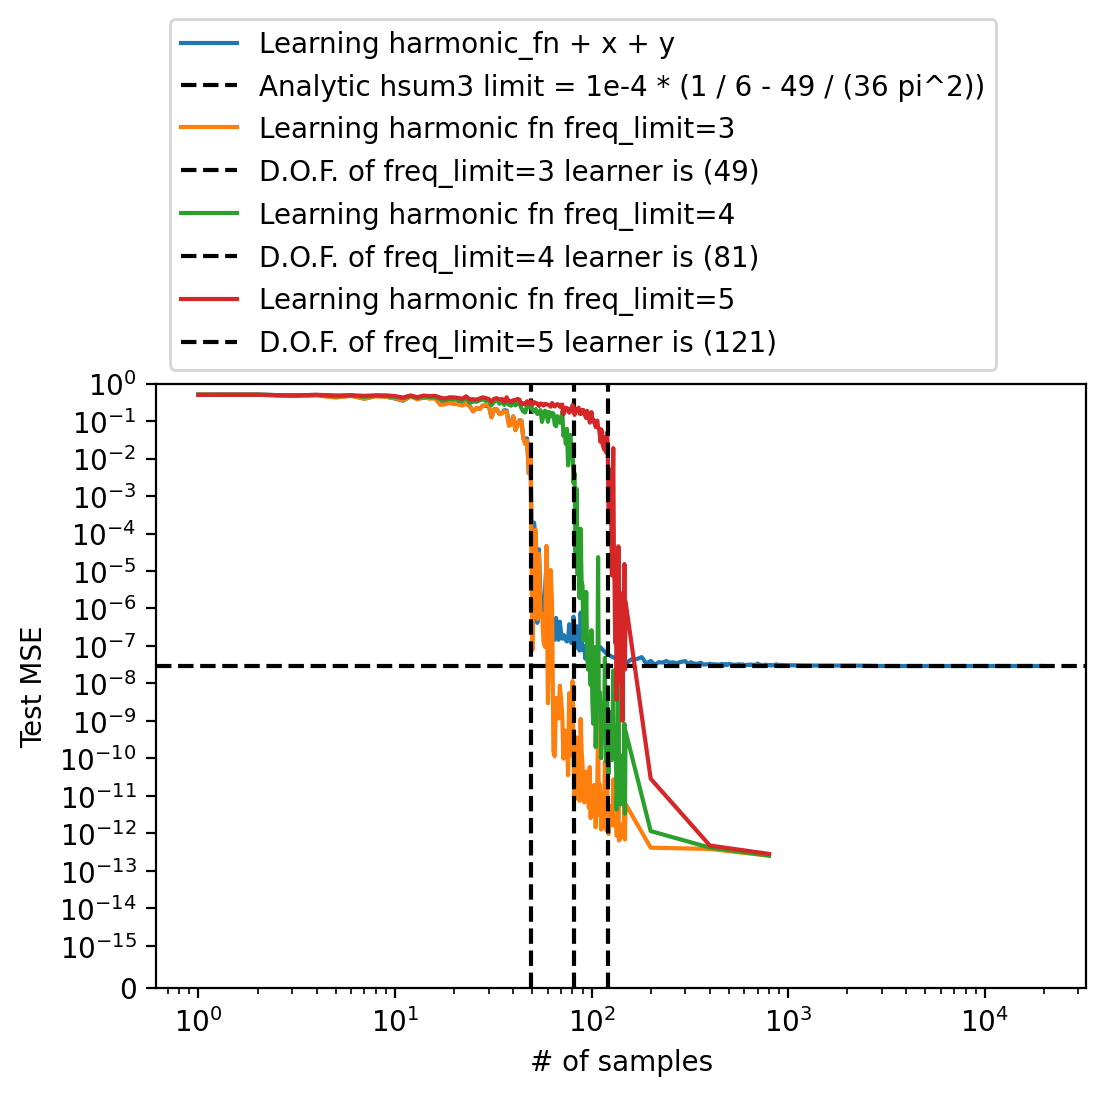

In [36]:
plt.figure(dpi=200)

# plt.plot(DATA["sum3"].ns, DATA["sum3"].val_mses, label="Learning x + y")
plt.plot(DATA["hsum3"].ns, DATA["hsum3"].val_mses, label="Learning harmonic_fn + x + y")
plt.axhline(
    DATA["hsum3lim"],
    color="black",
    linestyle="--",
    label="Analytic hsum3 limit = 1e-4 * (1 / 6 - 49 / (36 pi^2))",
)

for freq_limit in [3, 4, 5]:
    plt.plot(
        DATA[f"h{freq_limit}"].ns,
        DATA[f"h{freq_limit}"].val_mses,
        label=f"Learning harmonic fn {freq_limit=}",
    )
    plt.axvline(
        DATA[f"dof{freq_limit}"],
        color="black",
        linestyle="--",
        label=f"D.O.F. of {freq_limit=} learner is ({DATA[f'dof{freq_limit}']})",
    )

plt.xscale("log")
plt.yscale("symlog", linthresh=1e-15)
plt.ylim(0, 1)
plt.legend(loc="lower left", bbox_to_anchor=(0, 1))
plt.xlabel("# of samples")
plt.ylabel("Test MSE")


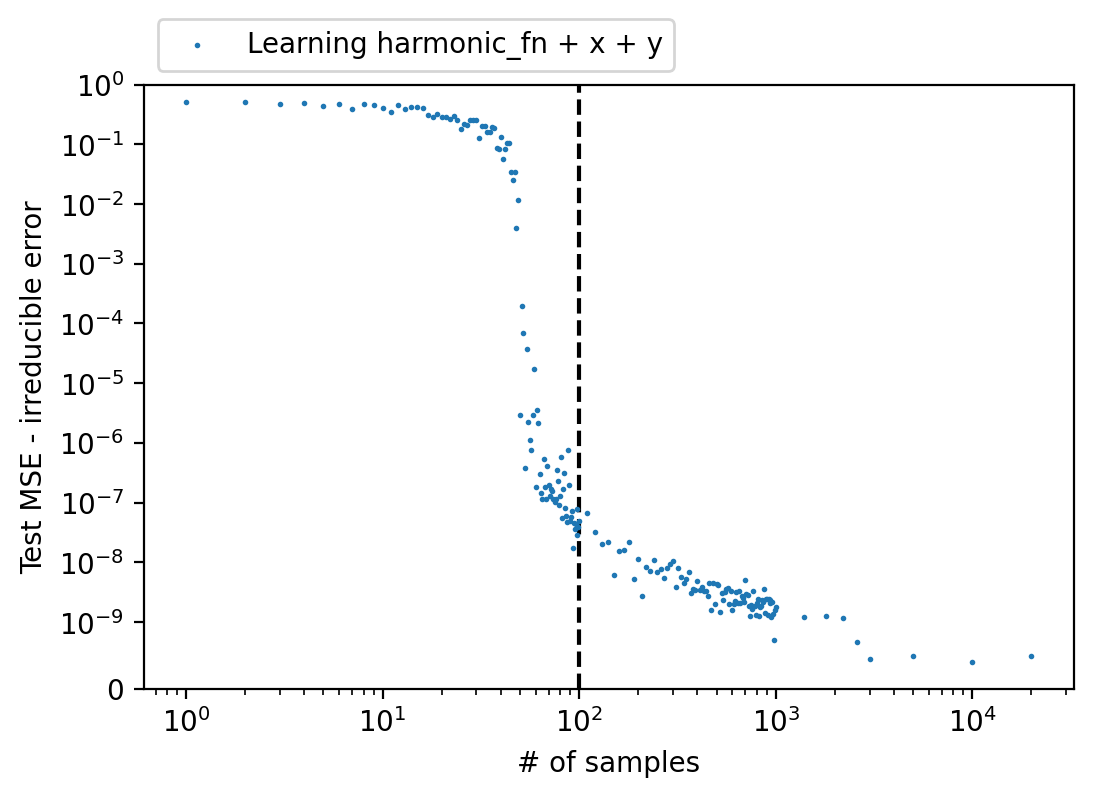

In [13]:
plt.figure(dpi=200)
plt.scatter(DATA["hsum3"].ns, DATA["hsum3"].val_mses - DATA["hsum3lim"], label="Learning harmonic_fn + x + y", s=1)

plt.axvline(100, color="black", linestyle="--", zorder=-3)
plt.xscale("log")
plt.yscale("symlog", linthresh=1e-9)
plt.ylim(0, 1)
plt.legend(loc="lower left", bbox_to_anchor=(0, 1))
plt.xlabel("# of samples")
plt.ylabel("Test MSE - irreducible error");